# S&P1500 STOCK PICKER
#### AUTHOR : THOMAS ROCHEFORT-BEAUDOIN
---

### Goal:
The goal of this python script will be to select stocks from the S&P1500 constituents in order to beat the S&P500 index on a monthly basis. To do so we will construct a machine learning algorithm which will train on the financial ratios of the companies in the S&P1500.

### Data used:
4 datasets are used:
- " ratios_1990_2019.csv " which consists of all the financial ratios of the Standard & Poor database from 1990 to 2019. The data is presented with the publication date of the various financial documents from which they are derived.

- " yield_1962_2019.csv " which consists of all the monthly yields of the companies in the Standard & Poor database from 1962 to 2019.

- " SP1500constituents.csv " which lists all the comapnies who are/were in the SP1500 index.

- " ^GSPC.csv " which holds the monthly closing price of the SP500 index.
 
 
 ### Methodology:
 1. The various datasets will first be merged into one main dataframe before the "Data Cleaning" steps:
     1. The monthly yields are presented with a date corresponding to the last day of the trading month. The ratios are presented with their respective publication date. We therefore need to match the most recent publication date that was available at the end of the trading month for every company in the monthly yields file.
     2. We need to generate the monthly return of the SP500 from the adjusted closing price and match with the monthly returns of the companies. We can then generate the column " WIN " which will hold a value of 0 if the monthly return of the stock is smaller than the monthly return of the SP500
     3. We need to get rid of the companies which were not in the SP1500 index at every month.
     4. We will save the generated dataframe as .pkl
     
2.  Data cleaning
3.  Feature Selection
4.  Training the Machine Learning algorithm and backtesting it

### Feature Selection:

The feature selection will be accomplished using the excellent feature_selector package from Will Koehrsen which you can find information at https://github.com/WillKoehrsen/feature-selector

 ### Machine Learning Algorithm:
 
 We will use a Random Forest regressor from SKlearn to try to predict the binary value of the " WIN " column. In other words:  We want to predict every month if a stock will beat the SP500 or not. The algorithm will train itself on a 7 year roling window period and then predict the following month. A rolling window keeps the algorithm dynamic (meaning its thinking will evolve over time) and the 7 year period corresponds to the historical average economic cycle.
 

In [74]:
## First we import the required packages:
import numpy as np
from datetime import timedelta
from IPython.display import clear_output
import time
from feature_selector import FeatureSelector
import pandas as pd
import datetime
import pickle
import progressbar
from sklearn.impute import SimpleImputer
import dateutil.relativedelta
import multiprocessing as mp

In [9]:
## We then load the required yield and financial ratios database:
ratio= pd.read_csv('ratios_1990_2019.csv')
ratio = ratio.convert_objects(convert_numeric=True)
yields=pd.read_csv('yield_1962_2019.csv')

ticker=yields.tic ## Save for later since convert_numeric will break the strings
yields = yields.convert_objects(convert_numeric=True)
yields.tic=ticker

# We wanna use the datetime format to facilitate the next steps so let's change it right now:
ratio.public_date=pd.to_datetime(ratio.public_date)
yields.datadate=pd.to_datetime(yields.datadate)

#remove non-common shares from database
yields = yields[yields.tpci == 0]  

## We will want to use only the constituents from the S&P1500
## The selection will be in the Data Cleaning section below
SP1500constituents=pd.read_csv('SP1500constituents.csv')
SP1500constituents['from_date']=pd.to_datetime(SP1500constituents['from_date'])
SP1500constituents['thru_date']=pd.to_datetime(SP1500constituents['thru_date'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


In [10]:
## To alleviate the memory needed we can keep only the data from January 1995:
d = datetime.datetime.strptime("1995-01-01", "%Y-%m-%d")
d2= datetime.datetime.strptime("2019-08-31", "%Y-%m-%d")
ratio= ratio[ratio["public_date"].isin(pd.date_range(d, d2))]
yields= yields[yields["datadate"].isin(pd.date_range(d, d2))]

# Let's reset the index:
ratio=ratio.reset_index(drop=True)
yields=yields.reset_index(drop=True)

#### Combining the datasets:
Now we want to combine both datasets on the columns "gvkey" and the date column.
For the financial ratios, the column "public_date" represents the date of publication of the financial report.
For the yields, the column ('datadate') represents the last day of the month where the return in the column "trt1m" is observed. We will use multiprocessing to iterate across the database and index the right ratios to the right date.

In [11]:
dict_new_entries = {}    # We are using a dictionary to append the list of rows                                                                                                                                                       
main=pd.DataFrame()      # Resulkting dataFrame converted from  dict_new_entries                                                                                                                                                      

yields_date = yields['datadate'] # Extract the columns we need. Much quicker for search/iterating                                                                                                                                       
yields_gvkey  = yields['gvkey']
ratio_gvkey     = ratio['gvkey']

number_columns = ratio.shape[1]           # Create empty row of the proper size. Will generate a row of NaNs                                                                                                                             
empty_row = [None] * number_columns

In [12]:
def mergedb(key):
    a = yields_date[key]
    b = yields_gvkey[key]
    rows_gvkey = ratio.loc[ratio['gvkey'] == b]                                                             ## Extract rows where 'stkcd' == b                                                                                           
    rows_date = rows_gvkey.loc[rows_gvkey['public_date'] < a].sort_values(by='public_date', ascending=True )  ## Extract subrows where public_date < a. Ascending sorting                                                                          

    if rows_date.size > 0:
        row_to_add = rows_date.tail(1)              ## Keep most recent entry, located at the end of the sorted list rows_annodt                                                                                                    
        dict_new_entries[key] = row_to_add.values[0]    ## Memorize this entry in dict                                                                                                                                                  

    else:
        dict_new_entries[key] = empty_row               ## Empty row. Will generate NaNs in every columns   
    return dict_new_entries[key]

In [13]:
## Multiprocessing of the function mergedb
nbrAvailCores = mp.cpu_count()
pool = mp.Pool(processes=nbrAvailCores)
resultsHandle = [pool.apply_async(mergedb, args=(z,)) for z in range(0, len(yields))]
results = [r.get() for r in progressbar.progressbar(resultsHandle)]
pool.close()

main = pd.DataFrame(results, columns=ratio.columns)

100% (3990930 of 3990930) |##############| Elapsed Time: 0:23:21 Time:  0:23:21


In [14]:
#We concatenate main and yields together
complete=pd.concat([yields,main],axis=1)
complete = complete[pd.notnull(complete['public_date'])]  ## Get rid of the NaN rows

In [15]:
complete.to_pickle("./database.pkl")   ## We save the intermediary dataframe

In [16]:
complete = pd.read_pickle("./database.pkl") ## This can serve as an intermediary step when running the notebook

In [17]:
SP500= pd.read_csv('^GSPC.csv',usecols=["Date", "Adj Close"])
SP500['sprtrn']= SP500['Adj Close'].pct_change()*100     ## Creates the column sprtrn with the monhtly SP500 return
SP500= SP500[np.isfinite(SP500['sprtrn'])]
SP500.Date=pd.to_datetime(SP500.Date)
complete = pd.merge(complete.assign(grouper=complete['datadate'].dt.to_period('M')),
               SP500.assign(grouper=SP500['Date'].dt.to_period('M')),
               how='left', on='grouper')

complete=complete.drop(columns=['grouper', 'Date','Adj Close'])
complete['win'] = np.where((complete.trt1m > complete.sprtrn) 
                     , 1, 0)
complete['decision_date']=complete.datadate+datetime.timedelta(1)


### Cleaning the dataset
---

In [18]:
complete = complete.loc[:,~complete.columns.duplicated()]

In [19]:
db = complete
SP1500=SP1500constituents
number_rows = complete.shape[0]
empty_row = [0] * number_rows
gvkeySP1500=SP1500['gvkey']
gvkey=db['gvkey']
date=db['datadate']

## Defining a function to keep only the constituent of the SP1500 each months. Will mark a 1 next to securities part of the index.
def findSP1500(key):
    if np.sum(gvkeySP1500==gvkey[key])>0:
        rows=SP1500.loc[SP1500['gvkey'] == gvkey[key]]
        if (rows.from_date.iloc[0]<=date[key]<rows.thru_date.iloc[0]) & len(rows):
            empty_row[key]=1     
        else:
            empty_row[key]=0
    else:
        empty_row[key]=0
    return (empty_row[key])

In [20]:
# Multiprocessing of the function findSP1500
nbrAvailCores = mp.cpu_count()
pool = mp.Pool(processes=nbrAvailCores)
resultsHandle = [pool.apply_async(findSP1500, args=(z,)) for z in range(0, len(complete))]
results = [r.get() for r in progressbar.progressbar(resultsHandle)]
pool.close()

100% (1829047 of 1829047) |##############| Elapsed Time: 0:01:35 Time:  0:01:35


In [21]:
complete['SP1500']=results
complete=complete[complete.SP1500==1] #remove non-SP1500 securities

In [22]:
complete.isna().sum()

gvkey                   0
iid                  1359
datadate                0
tic                     0
conm                    0
trt1m                5141
exchg                   0
tpci                    0
adate                 441
qdate                   0
public_date             0
CAPEI                2332
bm                   4764
evm                  1942
pe_op_basic          9984
pe_op_dil           74009
pe_exi              10594
pe_inc              10261
ps                    475
pcf                   940
dpr                 43310
npm                   475
opmbd                 475
opmad                 482
gpm                   490
ptpm                  475
cfm                  2909
roa                   967
roe                  5294
roce                 3336
                    ...  
dltt_be              5698
debt_assets           532
debt_capital         5328
de_ratio              535
intcov              63530
intcov_ratio        63542
cash_ratio          56652
quick_ratio 

In [23]:
## We cannot trade stocks with no monthly yields
clean_db1 = complete[np.isfinite(complete['trt1m'])]
## We can drop data that is not useful for us
clean_db=clean_db1.drop(columns=['iid','adate','qdate','public_date','tic','SP1500'])


In [24]:
## We do not want to use items where more than 50% of the rows are missing. 
clean_db = clean_db.loc[:, clean_db.isnull().mean() < .5]
clean_db['DIVYIELD'] = clean_db['DIVYIELD'].str.rstrip('%').astype('float') / 100.0 # convert DIVYIELD

In [25]:
## For the rest of the ratios, we will impute the missing values with the mean of the total column
imp=SimpleImputer(missing_values=np.nan, strategy="mean" )
#database1['ptb'] = imp.fit_transform(database1[['ptb']])
impute_columns=clean_db.columns[clean_db.isna().any()].tolist()
for i in impute_columns:
    clean_db[i] = imp.fit_transform(clean_db[[i]])
clean_db['tic']=clean_db1.tic


In [26]:
## We can now visualize the cleaned DB:
clean_db.head()

,gvkey,datadate,conm,trt1m,exchg,tpci,CAPEI,bm,evm,pe_op_basic,...,accrual,ptb,PEG_trailing,DIVYIELD,PEG_1yrforward,PEG_ltgforward,sprtrn,win,decision_date,tic
0,1004,1995-02-28,AAR CORP,1.8519,11.0,0.0,18.514,1.068,10.849,16.364,...,-0.062,0.963,0.046,0.0356,1.396,1.591086,3.607415,0,1995-03-01,AIR
1,1004,1995-03-31,AAR CORP,-11.8182,11.0,0.0,18.857,1.068,10.849,16.667,...,-0.062,0.981,0.047,0.0349,1.421,2.273000,2.732919,0,1995-04-01,AIR
2,1004,1995-04-30,AAR CORP,14.3918,11.0,0.0,16.628,1.068,10.849,14.697,...,-0.062,0.865,0.041,0.0396,1.253,2.004000,2.796036,1,1995-05-01,AIR
3,1004,1995-05-31,AAR CORP,10.9091,11.0,0.0,20.453,1.032,10.145,15.537,...,0.006,0.969,0.000,0.0349,1.325,2.119000,3.631171,1,1995-06-01,AIR
4,1004,1995-06-30,AAR CORP,17.2131,11.0,0.0,22.684,1.032,10.145,17.232,...,0.006,1.074,0.000,0.0315,1.713,2.350000,2.127854,1,1995-07-01,AIR


### Feature Selection

In [27]:
train = clean_db.drop(columns = ['win','conm','datadate','gvkey','trt1m','decision_date','tic'])
train_labels = clean_db['win']
fs = FeatureSelector(data = train, labels = train_labels)

5 features with a correlation magnitude greater than 0.97.



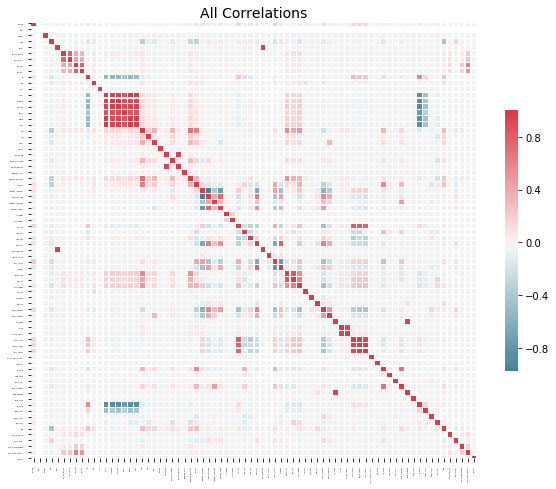

In [28]:
fs.identify_collinear(correlation_threshold=0.975)
fs.plot_collinear(plot_all=True)

In [29]:
fs.identify_zero_importance(task = 'regression', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.643037	valid_0's l2: 0.234656
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[887]	valid_0's auc: 0.635882	valid_0's l2: 0.236009
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[882]	valid_0's auc: 0.643785	valid_0's l2: 0.234676
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[996]	valid_0's auc: 0.643935	valid_0's l2: 0.234576
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.63893	valid_0's l2: 0.235618
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.640571	valid_0's l2: 0.23493
Training 

In [30]:
fs.identify_low_importance(cumulative_importance = 0.99)

70 features required for cumulative importance of 0.99 after one hot encoding.
4 features do not contribute to cumulative importance of 0.99.



In [31]:
all_to_remove = fs.check_removal()
print(all_to_remove)
clean_removed_db = clean_db.drop(columns = all_to_remove)

Total of 8 features identified for removal
['cfm', 'aftret_equity', 'debt_ebitda', 'ptpm', 'tpci', 'opmad', 'capital_ratio', 'debt_invcap']


In [32]:
clean_removed_db.drop_duplicates(keep=False,inplace=True) 

### TRADING ALGORITHM
---

In [33]:
def rfstockpicker_backtest(database,prediction_date,rolling_window,
                           nb_months,n_estimators,n_jobs):
    database = database
    results={}
    pd.options.mode.chained_assignment = None # Gets rid of a warning
    for i in range(0,nb_months):
        d = datetime.datetime.strptime(prediction_date, "%Y-%m-%d")

        d2 = d - dateutil.relativedelta.relativedelta(months=i)
        d3 = d - dateutil.relativedelta.relativedelta(months=i+1)
        d4 = d3 - dateutil.relativedelta.relativedelta(years=rolling_window)    ##Creating a rolling window interval
        
        test_set = database[database['decision_date'].isin(pd.date_range(d2, d2))]
        training_set=database[database['decision_date'].isin(pd.date_range(d4, d3))]

        # Labels are the values we want to predict
        train_labels = np.array(training_set['win'])
        # Remove the labels from the features
        columns_to_drop=['win','sprtrn','gvkey','datadate','conm','trt1m','decision_date','tic']
        train_features= training_set.drop(columns_to_drop, axis = 1)
        # Saving feature names for later use
        train_feature_list = list(train_features.columns)
        # Convert to numpy array
        train_features = np.array(train_features)
        
        test_labels = np.array(test_set['win'])
        # Remove the labels from the test features
        test_features= test_set.drop(columns_to_drop, axis = 1)
        # Convert to numpy array
        test_features = np.array(test_features)

        # Import the model we are using
        from sklearn.ensemble import RandomForestRegressor
        # Instantiate model 
        rf = RandomForestRegressor(n_estimators = n_estimators, random_state = 42,n_jobs=n_jobs)
        # Train the model on training data
        rf.fit(train_features, train_labels);

        # Use the forest's predict method on the test data
        stock_predictions = rf.predict(test_features)
        result_set=test_set
        result_set['predictions']=stock_predictions 
        results[i]=result_set

       # Get numerical feature importances
        importances = list(rf.feature_importances_)
        # List of tuples with variable and importance
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(train_feature_list, importances)]
        # Sort the feature importances by most important first
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        
    return results,feature_importances,importances,train_feature_list


In [34]:
results,feature_imp,importances,train_feature_list=rfstockpicker_backtest(clean_removed_db,("2018-12-01"),7,1,100,24)

In [35]:
portfolio=results[0].nlargest(10, 'predictions')
portfolio

,gvkey,datadate,conm,trt1m,exchg,CAPEI,bm,evm,pe_op_basic,pe_op_dil,...,ptb,PEG_trailing,DIVYIELD,PEG_1yrforward,PEG_ltgforward,sprtrn,win,decision_date,tic,predictions
570920,13714,2018-11-30,CBS CORP,-6.0785,11.0,12.998,0.124000,9.879,12.202,12.307,...,7.407000,1.048000,0.012600,0.486003,1.591086,1.785936,0,2018-12-01,CBS.A,0.98
571215,13714,2018-11-30,CBS CORP,-5.5275,11.0,12.998,0.124000,9.879,12.202,12.307,...,7.407000,1.048000,0.012600,0.486003,1.591086,1.785936,0,2018-12-01,CBS,0.98
697805,17934,2018-11-30,SPROUTS FARMERS MARKET,-14.3920,14.0,28.920,0.229000,10.180,21.862,22.223,...,5.313000,0.801000,0.022435,0.486003,1.591086,1.785936,0,2018-12-01,SFM,0.98
1792940,180652,2018-11-30,VERISK ANALYTICS INC,2.9039,14.0,44.324,0.137000,17.132,37.333,38.166,...,8.141000,2.917000,0.022435,0.486003,1.591086,1.785936,1,2018-12-01,VRSK,0.98
1155825,31843,2018-11-30,HARMONIC INC,1.9964,14.0,-12.288,0.608000,72.770,-11.479,-11.479,...,2.164000,-0.045000,0.022435,0.486003,1.591086,1.785936,1,2018-12-01,HLIT,0.97
1735826,165993,2018-11-30,FIDELITY NATIONAL INFO SVCS,3.6984,11.0,48.746,0.339000,13.630,40.193,40.664,...,2.866000,0.756000,0.012300,0.486003,1.591086,1.785936,1,2018-12-01,FIS,0.97
156468,4503,2018-11-30,EXXON MOBIL CORP,0.8032,11.0,15.907,0.611000,10.946,22.701,22.701,...,1.576000,1.521000,0.041200,0.486003,1.591086,1.785936,0,2018-12-01,XOM,0.96
293188,7585,2018-11-30,MOTOROLA SOLUTIONS INC,7.0904,11.0,67.278,0.569087,12.121,21.925,23.798,...,3.131228,2.329234,0.017000,0.486003,1.591086,1.785936,1,2018-12-01,MSI,0.96
364541,9225,2018-11-30,ROLLINS INC,7.8378,11.0,83.129,0.061000,29.510,40.687,40.687,...,18.566000,3.953000,0.011100,0.486003,1.591086,1.785936,1,2018-12-01,ROL,0.96
1597682,133504,2018-11-30,LUMINEX CORP,2.0855,14.0,46.203,0.360000,15.882,34.250,34.663,...,2.709000,1.465000,0.008340,0.486003,1.591086,1.785936,1,2018-12-01,LMNX,0.96


In [36]:
monthly_yields=[]
SP500_monthly_yields=[]
compounded_portfolio=1
compounded_SP500=1
for i in range(0,len(results)):
    monthly_yields.append((results[i].nlargest(5, 'predictions')).trt1m.mean().round(2))
    SP500_monthly_yields.append(results[i].sprtrn.mean().round(2))
    compounded_portfolio=(compounded_portfolio*(1+(monthly_yields[i]/100)))
    compounded_SP500=compounded_SP500*(1+(SP500_monthly_yields[i]/100))
print('The compounded return of the portfolio over the period is:',round(((compounded_portfolio-1))*100,2),'%')
print('The compounded return of the SP500 over the period is:',round((compounded_SP500-1)*100,2),'%')

The compounded return of the portfolio over the period is: -4.22 %
The compounded return of the SP500 over the period is: 1.79 %


In [37]:
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_imp];

Variable: CAPEI                Importance: 0.06
Variable: pcf                  Importance: 0.06
Variable: ptb                  Importance: 0.06
Variable: PEG_1yrforward       Importance: 0.06
Variable: ps                   Importance: 0.05
Variable: PEG_ltgforward       Importance: 0.05
Variable: pe_op_basic          Importance: 0.04
Variable: pe_op_dil            Importance: 0.04
Variable: pe_exi               Importance: 0.04
Variable: pe_inc               Importance: 0.04
Variable: PEG_trailing         Importance: 0.04
Variable: DIVYIELD             Importance: 0.04
Variable: bm                   Importance: 0.01
Variable: evm                  Importance: 0.01
Variable: dpr                  Importance: 0.01
Variable: npm                  Importance: 0.01
Variable: opmbd                Importance: 0.01
Variable: gpm                  Importance: 0.01
Variable: roa                  Importance: 0.01
Variable: roe                  Importance: 0.01
Variable: roce                 Importanc

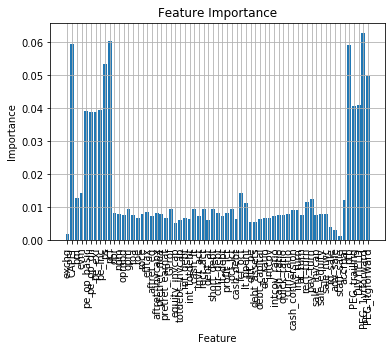

In [38]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, train_feature_list, rotation='vertical')
plt.grid(True)
plt.box(True)
plt.rcParams["figure.facecolor"] = "w"
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importance');
#plt.savefig('Importance des variables_1.png', bbox_inches = 'tight')

In [39]:
## We can see that a lot of labels have very small importance 
# Lets try removing features with importance value smaller than 0.02
df_importance = pd.DataFrame(feature_imp, columns = ['Feature', 'Importance']) 
feature_to_drop=df_importance.Feature[df_importance['Importance']<0.02]
new_db=clean_removed_db.drop(columns=feature_to_drop)

In [40]:
## We can run the same backtest over one month with the simplified db:
results2,feature_imp2,importances2,train_feature_list2=rfstockpicker_backtest(new_db,("2018-12-01"),7,1,100,24)

In [41]:
results2[0].nlargest(10, 'predictions')

,gvkey,datadate,conm,trt1m,CAPEI,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,...,ptb,PEG_trailing,DIVYIELD,PEG_1yrforward,PEG_ltgforward,sprtrn,win,decision_date,tic,predictions
51919,2176,2018-11-30,BERKSHIRE HATHAWAY,5.9456,11.279,25.952,25.952,10.664,10.664,1.176,...,0.783000,0.220000,0.022435,0.486003,1.591086,1.785936,1,2018-12-01,BRK.A,0.935
52199,2176,2018-11-30,BERKSHIRE HATHAWAY,6.3133,11.279,25.952,25.952,10.664,10.664,1.176,...,0.783000,0.220000,0.022435,0.486003,1.591086,1.785936,1,2018-12-01,BRK.B,0.935
1155825,31843,2018-11-30,HARMONIC INC,1.9964,-12.288,-11.479,-11.479,-10.396,-10.396,1.250,...,2.164000,-0.045000,0.022435,0.486003,1.591086,1.785936,1,2018-12-01,HLIT,0.930
1638810,142956,2018-11-30,OMNICELL INC,9.2362,127.616,81.264,83.176,57.951,57.951,3.714,...,4.494000,2.329234,0.022435,0.486003,1.591086,1.785936,1,2018-12-01,OMCL,0.930
1653933,147204,2018-11-30,COGENT COMMUNICATIONS HLDGS,-5.6368,135.522,106.082,108.292,226.000,226.000,4.772,...,3.131228,2.329234,0.041600,0.486003,1.591086,1.785936,0,2018-12-01,CCOI,0.920
1704668,162127,2018-11-30,CONSOLIDATED COMM HLDGS INC,9.9042,52.264,-25.551,-25.551,18.412,18.412,0.628,...,1.239000,0.009000,0.124000,0.486003,1.591086,1.785936,1,2018-12-01,CNSL,0.920
1787717,179666,2018-11-30,LOGMEIN INC,7.4431,193.336,141.180,143.533,32.996,32.996,3.899,...,1.335000,2.329234,0.013900,0.486003,1.591086,1.785936,1,2018-12-01,LOGM,0.920
233585,6266,2018-11-30,JOHNSON & JOHNSON,5.5790,27.940,21.504,22.185,305.000,321.000,4.653,...,5.321000,2.329234,0.025700,0.486003,1.591086,1.785936,1,2018-12-01,JNJ,0.910
293957,7620,2018-11-30,MURPHY OIL CORP,0.9102,-31.460,245.000,252.500,-39.825,-38.854,2.470,...,1.149000,2.329234,0.031400,0.486003,1.591086,1.785936,0,2018-12-01,MUR,0.900
571291,13721,2018-11-30,ZOETIS INC,4.2662,66.656,33.143,33.389,39.539,39.539,7.755,...,19.753000,0.978000,0.005590,0.486003,1.591086,1.785936,1,2018-12-01,ZTS,0.900


In [42]:
monthly_yields=[]
SP500_monthly_yields=[]
compounded_portfolio=1
compounded_SP500=1
for i in range(0,len(results2)):
    monthly_yields.append((results2[i].nlargest(5, 'predictions')).trt1m.mean().round(2))
    SP500_monthly_yields.append(results2[i].sprtrn.mean().round(2))
    compounded_portfolio=(compounded_portfolio*(1+(monthly_yields[i]/100)))
    compounded_SP500=compounded_SP500*(1+(SP500_monthly_yields[i]/100))
print('The compounded return of the portfolio over the period is:',round(((compounded_portfolio-1))*100,2),'%')
print('The compounded return of the SP500 over the period is:',round((compounded_SP500-1)*100,2),'%')

The compounded return of the portfolio over the period is: 3.57 %
The compounded return of the SP500 over the period is: 1.79 %


In [43]:
results3,feature_imp3,importances3,train_feature_list3=rfstockpicker_backtest(clean_removed_db,("2018-12-01"),7,(12*15),100,24)

In [44]:
monthly_yields=[]
monthly_date=[]
SP500_monthly_yields=[]
ret_model=[]
ret_SP500=[]
compounded_portfolio=1
compounded_SP500=1
for i in range(len(results3) - 1, -1,-1):
    monthly_yields.append((results3[i].nlargest(10, 'predictions')).trt1m.mean().round(2))
    SP500_monthly_yields.append(results3[i].sprtrn.mean().round(2))
    monthly_date.append(results3[i].datadate.iloc[0])
    
for i in range(0,len(monthly_yields)):
    compounded_portfolio=(compounded_portfolio*(1+(monthly_yields[i]/100)))
    compounded_SP500=(compounded_SP500*(1+(SP500_monthly_yields[i]/100)))
    
    ret_model.append(compounded_portfolio)
    ret_SP500.append(compounded_SP500)
    
print('The compounded return of the portfolio over the period is:',round(((compounded_portfolio)*100),2),'%')
print('The compounded return of the SP500 over the period is:',round((compounded_SP500)*100,2),'%')

The compounded return of the portfolio over the period is: 572.72 %
The compounded return of the SP500 over the period is: 260.95 %


In [45]:
results4,feature_imp4,importances4,train_feature_list4=rfstockpicker_backtest(new_db,("2018-12-01"),7,(12*15),100,24)

In [49]:
monthly_yields=[]
monthly_date=[]
SP500_monthly_yields=[]
ret_model=[]
ret_SP500=[]
compounded_portfolio=1
compounded_SP500=1
for i in range(len(results4) - 1, -1,-1):
    monthly_yields.append((results4[i].nlargest(10, 'predictions')).trt1m.mean().round(2))
    SP500_monthly_yields.append(results4[i].sprtrn.mean().round(2))
    monthly_date.append(results4[i].datadate.iloc[0])
for i in range(0,len(monthly_yields)):
    compounded_portfolio=(compounded_portfolio*(1+(monthly_yields[i]/100)))
    compounded_SP500=(compounded_SP500*(1+(SP500_monthly_yields[i]/100)))
    
    ret_model.append(compounded_portfolio)
    ret_SP500.append(compounded_SP500)
    
print('The compounded return of the portfolio over the period is:',round(((compounded_portfolio)*100),2),'%')
print('The compounded return of the SP500 over the period is:',round((compounded_SP500)*100,2),'%')

The compounded return of the portfolio over the period is: 1420.52 %
The compounded return of the SP500 over the period is: 260.95 %


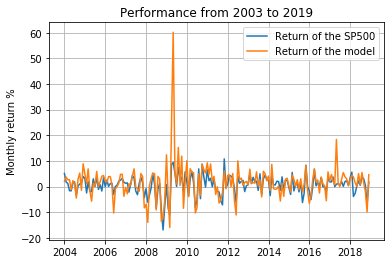

In [71]:
import matplotlib.pyplot as plt 

plt.plot(monthly_date,SP500_monthly_yields,label="Return of the SP500")
plt.plot(monthly_date,monthly_yields,label="Return of the model")

plt.ylabel('Monthly return %')
plt.title('Performance from 2003 to 2019')
plt.grid(True)
plt.legend()

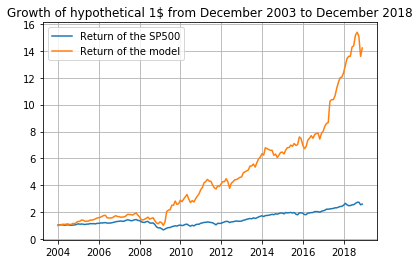

In [51]:
plt.plot(monthly_date,ret_SP500,label="Return of the SP500")
plt.plot(monthly_date,ret_model,label="Return of the model")

plt.ylabel('')
plt.title('Growth of hypothetical 1$ from December 2003 to December 2018')
plt.grid(True)
plt.legend()